# NLP Project - Relation Classification

In [1]:
# Uncomment the following lines to install required dependencies

# !pip install spacy
# !pip install nltk
# !pip install tqdm
# !pip install scikit-learn
# !pip install tensorflow
# !pip install keras
# !pip install matplotlib

### Task 1: Create a class CorpusReader that is able to read the data files and represent the information in a way such that your model can process it. 

In [2]:
# Imports
import os 
import re
from tqdm.notebook import trange, tqdm
import pickle
from typing import List

# Constants
TRAIN_FILE_PATH = "semeval_train.txt"
TEST_FILE_PATH = "semeval_test.txt"

TASK_NAME = "semeval"
PROCESSED_FILE_EXT = "-processed.pkl"

In [3]:
class ProcessedSentence:
    
    def __init__(self, idx: str, sentence_list: List[str], e1: str, e2:str, e1_idx: int, e2_idx:int, label:str=None):
        self.idx = idx
        self.sentence_list = sentence_list
        self.sentence = " ".join(sentence_list)
        self.e1 = e1
        self.e2 = e2
        self.e1_idx = e1_idx
        self.e2_idx = e2_idx
        self.label = label
        self.max_token_len = 0
        
        self.features = {}
        
    def __repr__(self):
        return f"ProcessedSentence(idx={self.idx}, sentence={self.sentence}, e1={self.e1}, e2={self.e2}, label={self.label})"

class CorpusReader:
    
    # Regex pattern of train and test sentence
    regex = r"(\d+)\t\"(.*<e1>(.*)<\/e1>.*<e2>(.*)<\/e2>.*)\".*\n"
    
    def __init__(self, train_file_path:str=None, test_file_path:str=None):
        self.train_file_path = train_file_path
        self.test_file_path = test_file_path
        self.train_sentences = []
        self.test_sentences = []
        self.max_token_len = 0
        
    def process_files(self, force:bool=False):
        file_found = False
        if not force:
            # Try loading dumped file if any
            try:                
                loaded_cr = CorpusReader.load_corpus_reader()
                file_found = True
                setattr(self, 'train_sentences', loaded_cr.train_sentences)
                setattr(self, 'test_sentences', loaded_cr.test_sentences)
                setattr(self, 'max_token_len', loaded_cr.max_token_len)
                return
            except:
                pass
        if force or not file_found:
            if not self.train_file_path or not self.test_file_path:
                raise Exception("Train file path/Test file path not specified")

            self.__process_file(self.train_file_path, 'train_sentences', force)
            self.__process_file(self.test_file_path, 'test_sentences', force)

            CorpusReader.save_corpus_reader(self)
        
        
        
    @staticmethod
    def clean_sentence(sentence:str):
        sentence = sentence.replace("'", " '")
        sentence = sentence.replace("<e1>", " <e1> ")
        sentence = sentence.replace("</e1>", " </e1> ")
        sentence = sentence.replace("<e2>", " <e2> ")
        sentence = sentence.replace("</e2>", " </e2> ")
        for ch in '.!"#$%&()*+,-:;=?@[\]^_`{|}~':
            if ch in sentence:
                sentence = sentence.replace(ch, " {} ".format(ch))
                
        sentence.strip()
        return sentence
    
    @staticmethod
    def load_corpus_reader(ext=PROCESSED_FILE_EXT):
        with open(TASK_NAME+ext, 'rb') as file:
            print("Loading from", TASK_NAME+ext)
            return pickle.load(file)
    
    @staticmethod            
    def save_corpus_reader(cr, ext=PROCESSED_FILE_EXT):
        with open(TASK_NAME+ext, "wb") as pkl:
            pickle.dump(cr, pkl)
            print("Corpus reader saved to", TASK_NAME+ext)
            
    def __process_file(self, filepath:str, attr:List[ProcessedSentence], force:bool=False):
        
        store = getattr(self, attr)
        
        with open(filepath, 'r', encoding='utf-8') as file:
            file_data = file.readlines()
            
        for i in trange(0, len(file_data), 4, desc=filepath):
            line = file_data[i]
            label = file_data[i+1].strip()
            
            processed_sentence = CorpusReader.process_sentence(line)
            processed_sentence.label = label
            store.append(processed_sentence)
        
        
    @staticmethod
    def process_sentence(line:str):
        match = re.match(CorpusReader.regex, line)
        if match:
            idx, sentence, e1, e2 = map(lambda x: x.strip(), match.groups())
        else:
            regex = r"(.*<e1>(.*)<\/e1>.*<e2>(.*)<\/e2>.*)"
            match = re.match(regex, line)
            if match:
                sentence, e1, e2 = map(lambda x: x.strip(), match.groups())
                idx = None
            else:
                return None
            
        clean_sentence = CorpusReader.clean_sentence(sentence)
        sen_list = clean_sentence.split()
        e1_idx = sen_list.index('<e1>') + 1
        e2_idx = sen_list.index('<e2>') + 1
        
        sen_list.remove("<e1>")
        sen_list.remove("</e1>")
        sen_list.remove("<e2>")
        sen_list.remove("</e2>")
            
        e1_idx -= 1; e2_idx -= 3
            
        return ProcessedSentence(idx, sen_list, e1, e2, e1_idx, e2_idx)
    
    def __repr__(self):
        return f"CorpusReader(train_sentences_len={len(self.train_sentences)}, test_sentences_len={len(self.test_sentences)})"
        

In [4]:
cr = CorpusReader(TRAIN_FILE_PATH, TEST_FILE_PATH)
print("Processing files")
cr.process_files()
print(cr)
print()
print("Sample Processed Sentence:")
print("Train:", cr.train_sentences[0])
print("Test:", cr.test_sentences[0])

Processing files
Loading from semeval-processed.pkl
CorpusReader(train_sentences_len=8000, test_sentences_len=2717)

Sample Processed Sentence:
Train: ProcessedSentence(idx=1, sentence=The system as described above has its greatest application in an arrayed configuration of antenna elements ., e1=configuration, e2=elements, label=Component-Whole(e2,e1))
Test: ProcessedSentence(idx=8001, sentence=The most common audits were about waste and recycling ., e1=audits, e2=waste, label=Message-Topic(e1,e2))


### Task 2: Implement a deep NLP pipeline to extract the following NLP based features from the natural language statements:

- Tokenize the sentence into words.
- Lemmatize the words to extract lemmas as features
- Part-of-speech (POS) tag the words to extract POS tag features
- Perform dependency parsing or full-syntactic parsing to get parse-tree based patterns as features
- Using WordNet, extract hypernymns, hyponyms, meronyms, and holonyms as features
- Using an API like SpaCy, extract the named entity (NER) tags of the two named entities between which relation holds.

In [5]:
import spacy 

# # Uncomment the following lines if wordnet and spacy models are to be downloaded
import nltk
nltk.download('wordnet')
# spacy.cli.download('en_core_web_lg')

from nltk.corpus import wordnet as wn

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shankar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
sp = spacy.load('en_core_web_md')

def extract_feature_of_sentence(processed_sentence: ProcessedSentence, force=False):    
    if not force and processed_sentence.features:
        return processed_sentence.features       
    
    sentence = processed_sentence.sentence
    doc = sp(sentence)
    
    features = {}
    features['tokens'] = []
    features['pos_tags'] = []
    features['dep_parse'] = []
    features['lemmas'] = []
    features['ners'] = []
    features['hypernyms'] = []
    features['hyponyms'] = [] 
    features['meronyms'] = [] 
    features['holonyms'] = []

    for token in doc:
        features['tokens'].append(token.text)
        features['pos_tags'].append(token.tag_)
        features['dep_parse'].append(token.dep_)
        features['lemmas'].append(token.lemma_)
        
        try:
            wn_pos = getattr(wn, token.pos_)
            synsets = wn.synsets(token.text, pos=wn_pos)
        except AttributeError:
            synsets = wn.synsets(token.text)

        if synsets:
            synset = synsets[0]
            hypernyms = synset.hypernyms()
            if hypernyms:
                features['hypernyms'].append((token.text, hypernyms[0].name().split('.')[0]))
            hyponyms = synset.hyponyms()
            if hyponyms:
                features['hyponyms'].append((token.text,hyponyms[0].name().split('.')[0]))
            meronyms = synset.part_meronyms()
            if meronyms:
                features['meronyms'].append((token.text, meronyms[0].name().split('.')[0]))
            holonyms = synset.part_holonyms()
            if holonyms:
                features['holonyms'].append((token.text, holonyms[0].name().split('.')[0]))
        
    e1e2 = sp(processed_sentence.e1 + " " + processed_sentence.e2)
    for ent in e1e2.ents:
        features['ners'].append((ent.text, ent.label_))
        
    return features

In [7]:
EXTRACTED_FEATURE_EXT = "-features.pkl"

def extract_features(cr:CorpusReader, force:bool=False):
    
    if not force:
        try:
            return CorpusReader.load_corpus_reader(EXTRACTED_FEATURE_EXT)
        except:
            pass
    
    max_token_len = 0
    print("Extracting features of train sentences")    
    for s in tqdm(cr.train_sentences):
        features = extract_feature_of_sentence(s)
        s.features = features
        max_token_len = max(len(features['tokens']), max_token_len)
    
    print("Extracting features of test sentences")        
    for s in tqdm(cr.test_sentences):
        features = extract_feature_of_sentence(s)
        s.features = features
        max_token_len = max(len(features['tokens']), max_token_len)
        
        
    cr.max_token_len = max_token_len
    CorpusReader.save_corpus_reader(cr, EXTRACTED_FEATURE_EXT)
    return cr

In [8]:
print("Extracting features")
cr = extract_features(cr)
print("Sample Extracted Training sentence feature\n", cr.train_sentences[0].features)
print()
print("Sample Extracted Testing sentence feature\n", cr.test_sentences[0].features)

Extracting features
Loading from semeval-features.pkl
Sample Extracted Training sentence feature
 {'tokens': ['The', 'system', 'as', 'described', 'above', 'has', 'its', 'greatest', 'application', 'in', 'an', 'arrayed', 'configuration', 'of', 'antenna', 'elements', '.'], 'pos_tags': ['DT', 'NN', 'IN', 'VBN', 'RB', 'VBZ', 'PRP$', 'JJS', 'NN', 'IN', 'DT', 'VBN', 'NN', 'IN', 'JJ', 'NNS', '.'], 'dep_parse': ['det', 'nsubj', 'mark', 'acl', 'advmod', 'ROOT', 'poss', 'amod', 'dobj', 'prep', 'det', 'amod', 'pobj', 'prep', 'compound', 'pobj', 'punct'], 'lemmas': ['the', 'system', 'as', 'describe', 'above', 'have', '-PRON-', 'great', 'application', 'in', 'an', 'array', 'configuration', 'of', 'antenna', 'element', '.'], 'ners': [], 'hypernyms': [('system', 'instrumentality'), ('as', 'chemical_element'), ('described', 'set_forth'), ('has', 'angular_distance'), ('its', 'engineering'), ('application', 'use'), ('in', 'linear_unit'), ('an', 'associate_degree'), ('arrayed', 'arrange'), ('configuration',

In [9]:
print("Maximum token Length =", cr.max_token_len)

Maximum token Length = 97


### Task 3: Implement a machine-learning, statistical, or heuristic (or a combination) based approach to determine the relation and its direction for the given pair of arguments:

In [10]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import keras

GLOVE_WORD2VEC_PATH = r"glove.6B.300d.txt"
PROCESSED_EMBEDDINGS_EXT = "-Embeddings.pkl"

Using TensorFlow backend.


In [11]:
# # Download and extract GloVe word embeddings
# # Uncomment the following lines if GloVe vectors are to be downloaded

# path_to_glove = keras.utils.get_file(
#     "glove.6B.zip",
#     "http://nlp.stanford.edu/data/glove.6B.zip",
#     extract=True)

# GLOVE_WORD2VEC_PATH = os.path.join(os.path.split(path_to_glove)[0], GLOVE_WORD2VEC_PATH)

In [12]:
class Embeddings:

    GLOVE_WORD2VEC_DIM = 300
    
    UNKNOWN_TOKEN = 'UNKNOWN_TOKEN'
    PADDING_TOKEN = 'PADDING_TOKEN'
    
    
    def __init__(self, word2vec_path: str):
        self.word2vec_path = word2vec_path
        self.word2vec_idx = {}
        self.word2vec = []        
        self.vocab = set()
        
    def build_vocabulary(self, cr: CorpusReader):
        for ts in tqdm(cr.train_sentences + cr.test_sentences):
            for token in ts.features['tokens']:
                if token.lower() not in self.vocab:
                    self.vocab.add(token.lower())
                
        print("Vocabulary Length", len(self.vocab))
    
    def load_word_vectors(self):
        self.word2vec_idx[Embeddings.PADDING_TOKEN] = 0
        zero_vector = np.zeros(Embeddings.GLOVE_WORD2VEC_DIM)
        self.word2vec.append(zero_vector)

        self.word2vec_idx[Embeddings.UNKNOWN_TOKEN] = 1
        avg_vector = np.random.normal(0, np.sqrt(0.25), Embeddings.GLOVE_WORD2VEC_DIM)
        self.word2vec.append(avg_vector)
        
        with open(self.word2vec_path, 'r', encoding="utf8") as w2v_file:
            raw_vectors = w2v_file.readlines()
            for line in tqdm(raw_vectors):
                split = line.strip().split()
                word = split[0]
                if word.lower() in self.vocab:
                    self.word2vec_idx[word.lower()] = len(self.word2vec_idx)
                    try:
                        vector = np.array([float(x) for x in split[1:]])
                        self.word2vec.append(vector)
                    except ValueError as e:
                        print("Could not create vector")
                        print(split)
        self.word2vec = np.array(self.word2vec)
    
    def get_vector(self, word):
        return self.word2vec[get_vector_idx(word)]

    def get_vector_idx(self, word):
        if word in self.word2vec_idx:
            return self.word2vec_idx[word]
        elif word.lower() in self.word2vec_idx:
            return self.word2vec_idx[word.lower()]
        return self.word2vec_idx[Embeddings.UNKNOWN_TOKEN]
    
    def __repr__(self):
        return f"Embeddings(word2vec_path={self.word2vec_path}, vocab_len={len(self.vocab)}, word2vec_len={len(self.word2vec)})"
        

In [13]:
def init_word_vectors(cr: CorpusReader, force:bool =False):
    if not force:
        try:
            with open(TASK_NAME + PROCESSED_EMBEDDINGS_EXT, 'rb') as file:
                print("Loading from", TASK_NAME + PROCESSED_EMBEDDINGS_EXT)
                embeddings = pickle.load(file)
            return embeddings
        except:
            pass
    embeddings = Embeddings(GLOVE_WORD2VEC_PATH)
    embeddings.build_vocabulary(cr)
    embeddings.load_word_vectors()
    
    with open(TASK_NAME + PROCESSED_EMBEDDINGS_EXT, "wb") as pkl:
        pickle.dump(embeddings, pkl)
        print("Processed word vectors saved to", TASK_NAME + PROCESSED_EMBEDDINGS_EXT)
        
    return embeddings
    
embeddings = init_word_vectors(cr)

Loading from semeval-Embeddings.pkl


In [14]:
MODEL_DATA_PATH_EXT = "-model-input.pkl"

class ModelData:
        
    def __init__(self, word_embeddings, pos_embeddings, labels):
        self.word_embeddings = word_embeddings
        self.pos_embeddings = pos_embeddings
        self.labels = labels
        self.classes = None
        self.label_encoder = None
        self.Y = None
    
    def encode_labels(self, label_encoder):
        self.label_encoder = label_encoder
        self.classes = label_encoder.classes_
        self.Y = np.array(label_encoder.transform(self.labels), dtype='int32')       
        
    def __repr__(self):
        return f"ModelData(word_emb.shape={self.word_embeddings.shape}, pos_embeddings.shape={self.pos_embeddings[0].shape}, Y.shape={self.Y.shape if self.Y else None})"
        

In [15]:
def construct_model_input(processed_sentences: List[ProcessedSentence], embeddings: Embeddings):
    labels = [ps.label for ps in processed_sentences]
    
    input_dim = (len(processed_sentences), cr.max_token_len)

    word_emb = np.zeros(input_dim)
    e1_emb = np.zeros(input_dim)
    e2_emb = np.zeros(input_dim)

    for idx, ps in enumerate(processed_sentences):
        word_emb[idx, :len(ps.sentence_list)] = [embeddings.get_vector_idx(word) for word in ps.sentence_list]
        e1_emb[idx] = [abs(i - int(ps.e1_idx)) for i in range(cr.max_token_len)]
        e2_emb[idx] = [abs(i - int(ps.e2_idx)) for i in range(cr.max_token_len)]
    return ModelData(word_emb, [e1_emb, e2_emb], labels)

In [16]:
def load_data(filepath, ext=MODEL_DATA_PATH_EXT):
    with open(filepath+ext, 'rb') as file:
        print("Loading from", filepath+ext)
        return pickle.load(file)

def do_preprocessing(force:bool = False):
    if not force:
        try:
            return load_data(TRAIN_FILE_PATH), load_data(TEST_FILE_PATH)
        except:
            pass
            
    train_data = construct_model_input(cr.train_sentences, embeddings)
    test_data = construct_model_input(cr.test_sentences, embeddings)
    label_encoder = LabelEncoder()
    label_encoder.fit(train_data.labels)
    label_encoder.fit(test_data.labels)

    train_data.encode_labels(label_encoder)
    test_data.encode_labels(label_encoder)
    
    with open(TRAIN_FILE_PATH+MODEL_DATA_PATH_EXT, 'wb') as file:
        pickle.dump(train_data, file)
        print("Saving train model data to", TRAIN_FILE_PATH+MODEL_DATA_PATH_EXT)

    with open(TEST_FILE_PATH+MODEL_DATA_PATH_EXT, 'wb') as file:
        pickle.dump(test_data, file)
        print("Saving train model data to", TEST_FILE_PATH+MODEL_DATA_PATH_EXT)
    return train_data, test_data

train_data, test_data = do_preprocessing()
label_encoder = train_data.label_encoder
classes = label_encoder.classes_

Loading from semeval_train.txt-model-input.pkl
Loading from semeval_test.txt-model-input.pkl


In [17]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, concatenate
from keras.layers import Embedding
from keras.layers import Convolution1D, GlobalMaxPooling1D
from keras import regularizers
import tensorflow as tf

In [18]:
# Hyperparameters

EPOCHS = 10
BATCH_SIZE = 64
DROPOUT_PROB = 0.25
FILTER_SIZE = 256
KERNEL_SIZES = [3, 4, 5]
STRIDES = 1
POS_EMB_DIM = 97
REGULARIZE_RATE = 1e-4

In [19]:
emb = embeddings.word2vec
num_classes = len(classes)

def build_model():
    sentence_emb_input = Input(shape=(cr.max_token_len,), dtype='float32', name="sentence_emb")
    sentence_emb = Embedding(emb.shape[0], emb.shape[1], weights=[emb], trainable=False)(sentence_emb_input)
    
    e1_emb_input = Input(shape=(cr.max_token_len,), dtype='float32', name='e1_emb')
    e1_emb = Embedding(cr.max_token_len, POS_EMB_DIM)(e1_emb_input)

    e2_emb_input = Input(shape=(cr.max_token_len,), dtype='float32', name='e2_emb')
    e2_emb = Embedding(cr.max_token_len, POS_EMB_DIM)(e2_emb_input)

    x = concatenate([sentence_emb, e1_emb, e2_emb])
    yy = tf.expand_dims(x, axis=-1)
    input_dim = yy.shape.as_list()[2]

    for kernel_size in KERNEL_SIZES:
        x = Convolution1D(filters=FILTER_SIZE,
                                kernel_size=kernel_size,
                                padding='same',
                                activation='tanh',
                                strides=STRIDES,
                                kernel_regularizer=regularizers.l2(REGULARIZE_RATE))(x)
    x = GlobalMaxPooling1D()(x)
    y = Dropout(DROPOUT_PROB)(x)
    output = Dense(num_classes, activation='softmax')(y)

    model = Model(name = "Relation-Classification", inputs=[sentence_emb_input, e1_emb_input, e2_emb_input], outputs=[output])
    model.compile(loss='sparse_categorical_crossentropy', 
                    optimizer='adam',
                    metrics=['acc'])
    model.summary()
    
    return model

model = build_model()

Model: "Relation-Classification"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_emb (InputLayer)       (None, 97)           0                                            
__________________________________________________________________________________________________
e1_emb (InputLayer)             (None, 97)           0                                            
__________________________________________________________________________________________________
e2_emb (InputLayer)             (None, 97)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 97, 300)      6410100     sentence_emb[0][0]               
____________________________________________________________________________

In [20]:
TRAINED_MODEL_DIR = TASK_NAME + "-model"

def train_model(train_data, model, force=False):
    if not force:
        try:
            model = keras.models.load_model(TRAINED_MODEL_DIR)
            print("Model Loaded from", TRAINED_MODEL_DIR)
            return model
        except:
            pass
    
    for i in trange(EPOCHS):
        model.fit([train_data.word_embeddings,
                   train_data.pos_embeddings[0],
                   train_data.pos_embeddings[1]], 
                  train_data.Y,
                  batch_size=BATCH_SIZE, 
                  epochs=1)

    model.save(TRAINED_MODEL_DIR)    
    return model

model = train_model(train_data, model)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
8000/8000 [==============================] - 17s 2ms/step - loss: 1.7469 - acc: 0.4803
Epoch 1/1
8000/8000 [==============================] - 19s 2ms/step - loss: 1.0160 - acc: 0.7035
Epoch 1/1
8000/8000 [==============================] - 20s 3ms/step - loss: 0.7958 - acc: 0.7689
Epoch 1/1
8000/8000 [==============================] - 19s 2ms/step - loss: 0.6096 - acc: 0.8366
Epoch 1/1
8000/8000 [==============================] - 18s 2ms/step - loss: 0.4938 - acc: 0.8764
Epoch 1/1
8000/8000 [==============================] - 18s 2ms/step - loss: 0.3944 - acc: 0.9166
Epoch 1/1
8000/8000 [==============================] - 18s 2ms/step - loss: 0.3000 - acc: 0.9526
Epoch 1/1
8000/8000 [==============================] - 18s 2ms/step - loss: 0.2547 - acc: 0.9705
Epoch 1/1
8000/8000 [==============================] - 18s 2ms/step - loss: 0.2077 - acc: 0.9850
Epoch 1/1
8000/8000 [==============================] - 19s 2ms/step - loss: 0.1849 - acc: 0.9904




### Task 4: The performance of your system will evaluated on the test set. 

- On the test set, evaluate your system. Specifically, compute the 

    - accuracy 
    - macro precision
    - recall 
    - F-scores 
    
for the predictions made by your model under two settings

1. Assuming that the relation is classified correctly (but not the direction)
2. Assuming both the relation and direction are classified correctly.

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time 

import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def matprint(mat, fmt="g"):
        col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
        for x in mat:
            for i, y in enumerate(x):
                print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
            print("")
            
def plot_cm(cm, labels):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap="Greys")
    fig.colorbar(cax)
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)
    plt.show()

Computing metrics in Setting 1

Time taken to make predictions = 1.9978737831115723
Accuracy: 0.7563489142436511
Macro precision 0.7612122020302865
Recall 0.7754144769029652
F1 0.766926469654596


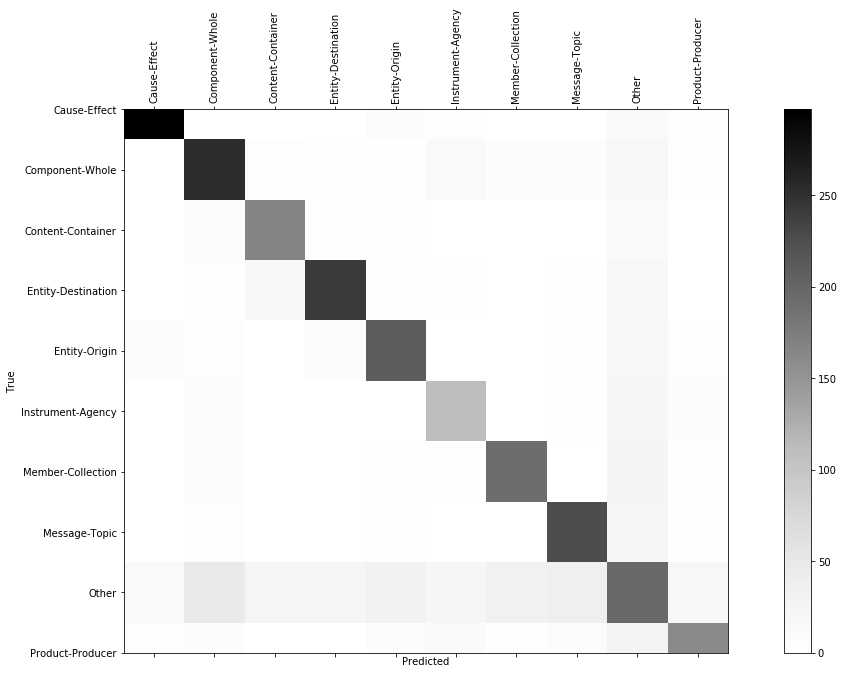

In [23]:
def compute_metrics(y_true, y_pred, classes):
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)
    
    macro_precision = precision_score(y_true, y_pred, average='macro', labels=np.unique(y_pred))
    print("Macro precision", macro_precision)
    
    recall = recall_score(y_true, y_pred, average='macro', labels=np.unique(y_pred))
    print("Recall", recall)
    
    f1 = f1_score(y_true, y_pred, average='macro', labels=np.unique(y_pred))
    print("F1", f1)
    
    cm = confusion_matrix(y_true, y_pred)
    
    # print("Confusion matrix")
    # matprint(cm)
    plot_cm(cm, list(classes))

def compute_metrics_setting_1(test_data, model):
    print("Computing metrics in Setting 1\n")
    
    labels_idx = {}
    label_groups = {}
    
    def group_labels():
        
        for idx, cls in enumerate(classes):
            relation = cls.split('(')[0]
            if relation not in labels_idx:
                labels_idx[relation] = idx
            label_groups[idx] = labels_idx[relation]
                
        return label_groups
    
    start_time = time.time()
    
    y_pred = model.predict([
                test_data.word_embeddings, 
                test_data.pos_embeddings[0], 
                test_data.pos_embeddings[1]], verbose=False).argmax(axis=1)
    
    end_time = time.time()
    
    print("Time taken to make predictions =", end_time-start_time)
    
    label_groups = group_labels()
    
    yt = np.copy(test_data.Y)
    yp = np.copy(y_pred)
    for k, v in label_groups.items():
        yt[yt == k] = v
        yp[yp == k] = v
    
    compute_metrics(yt, yp, labels_idx.keys())   
        
    
compute_metrics_setting_1(test_data, model)

Computing metrics in Setting 2

Accuracy: 0.7442031652557969
Macro precision 0.7556888716095342
Recall 0.7442527289421387
F1 0.7466610466568234


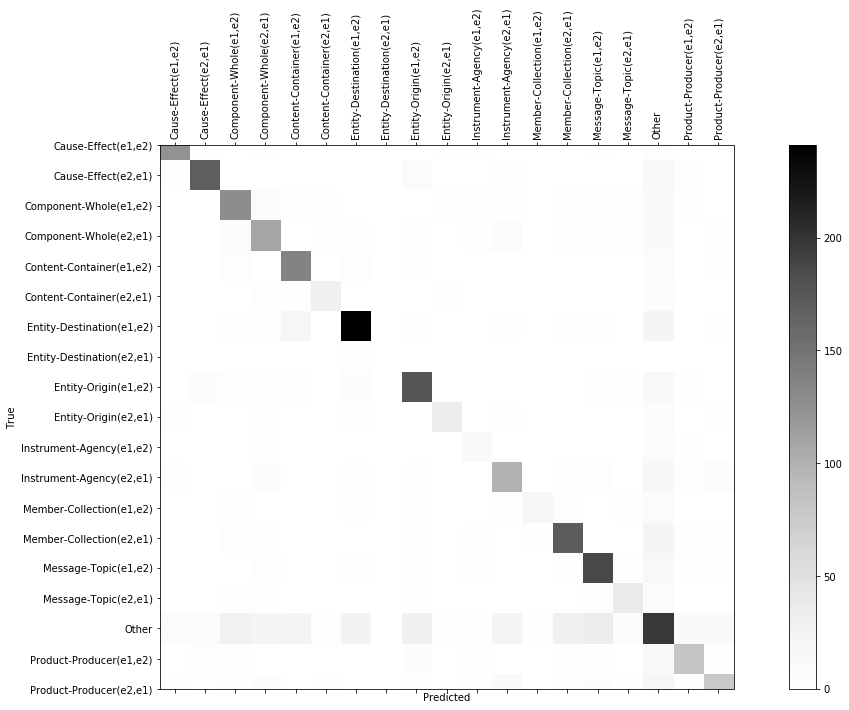

In [24]:
def compute_metrics_setting_2(test_data, model):
    print("Computing metrics in Setting 2\n")
    
    y_pred = model.predict([
                test_data.word_embeddings, 
                test_data.pos_embeddings[0], 
                test_data.pos_embeddings[1]], verbose=False).argmax(axis=1)
    
    
    compute_metrics(test_data.Y, y_pred, test_data.classes)
    
compute_metrics_setting_2(test_data, model)

### Demo

In [25]:
input_str = "The male took over the entire care of the <e1>young</e1> that had left the <e2>nest</e2>." 
# Entity-Origin(e1,e2)

# input_str = input()

In [26]:
start_time = time.time()

processed_sentence = CorpusReader.process_sentence(input_str)
print("Processed sentence", processed_sentence)
print("Extracted features")
print(extract_feature_of_sentence(processed_sentence))
X = construct_model_input([processed_sentence], embeddings)
y_pred = model.predict([
                X.word_embeddings, 
                X.pos_embeddings[0], 
                X.pos_embeddings[1]], verbose=False).argmax(axis=1)
pred_label = classes[y_pred]
processed_sentence.label = pred_label

end_time = time.time()

Processed sentence ProcessedSentence(idx=None, sentence=The male took over the entire care of the young that had left the nest ., e1=young, e2=nest, label=None)
Extracted features
{'tokens': ['The', 'male', 'took', 'over', 'the', 'entire', 'care', 'of', 'the', 'young', 'that', 'had', 'left', 'the', 'nest', '.'], 'pos_tags': ['DT', 'NN', 'VBD', 'RP', 'DT', 'JJ', 'NN', 'IN', 'DT', 'JJ', 'WDT', 'VBD', 'VBN', 'DT', 'NN', '.'], 'dep_parse': ['det', 'nsubj', 'ROOT', 'prt', 'det', 'amod', 'dobj', 'prep', 'det', 'pobj', 'nsubj', 'aux', 'relcl', 'det', 'dobj', 'punct'], 'lemmas': ['the', 'male', 'take', 'over', 'the', 'entire', 'care', 'of', 'the', 'young', 'that', 'have', 'leave', 'the', 'nest', '.'], 'ners': [], 'hypernyms': [('male', 'animal'), ('took', 'act'), ('over', 'part'), ('care', 'work'), ('nest', 'natural_object')], 'hyponyms': [('male', 'bullock'), ('over', 'maiden_over'), ('care', 'babysitting'), ('had', 'bear'), ('left', 'come_away'), ('nest', 'beehive')], 'meronyms': [], 'holony

In [27]:
print(f"Predicted relation for {input_str} is")
print(pred_label)
print(f"Prediction time = {end_time - start_time} seconds")

Predicted relation for The male took over the entire care of the <e1>young</e1> that had left the <e2>nest</e2>. is
['Entity-Origin(e1,e2)']
Prediction time = 1.6436443328857422 seconds
